In [55]:
import pandas as pd
import numpy as np
np.random.seed(1337)
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_curve, roc_auc_score

In [56]:
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers

In [57]:
def clean_data(x, y=None, scaler=None):
    x = x.drop('patient_id', axis=1)
    x = pd.get_dummies(x)
    x = x.drop('thal_reversible_defect', axis=1)
    if y is not None:
        y = y['heart_disease_present']
    if scaler is None:
        scaler = StandardScaler().fit(x)
    x = scaler.transform(x)
    return scaler, x, y

In [58]:
x = pd.read_csv('../Data/train_values.csv')
y = pd.read_csv('../Data/train_labels.csv')
x_test = pd.read_csv('../Data/test_values.csv')
patient_id_test = x_test['patient_id']
x = x.drop('patient_id', axis=1)
x_test = x_test.drop('patient_id', axis=1)
y = y['heart_disease_present']

In [59]:
categorical_vars= ['thal', 'chest_pain_type', 'fasting_blood_sugar_gt_120_mg_per_dl', 'sex', 'exercise_induced_angina']
for col in x.columns:
    if col not in categorical_vars:
        mean = x[col].mean()
        std = x[col].std()
        x[col] = (x[col] - mean)/std
        
x = pd.get_dummies(x, columns=categorical_vars)

for col in x_test.columns:
    if col not in categorical_vars:
        mean = x_test[col].mean()
        std = x_test[col].std()
        x_test[col] = (x_test[col] - mean)/std
        
x_test = pd.get_dummies(x_test, columns=categorical_vars)


x.head()

,slope_of_peak_exercise_st_segment,resting_blood_pressure,num_major_vessels,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,age,max_heart_rate_achieved,thal_fixed_defect,thal_normal,...,chest_pain_type_1,chest_pain_type_2,chest_pain_type_3,chest_pain_type_4,fasting_blood_sugar_gt_120_mg_per_dl_0,fasting_blood_sugar_gt_120_mg_per_dl_1,sex_0,sex_1,exercise_induced_angina_0,exercise_induced_angina_1
0,-0.888762,-0.194652,-0.716404,0.951196,1.115158,-0.900694,-1.051032,0.929891,0,1,...,0,1,0,0,1,0,0,1,1,0
1,0.727169,-1.252825,-0.716404,-1.051322,-0.667915,0.526148,-0.086892,0.386007,0,1,...,0,0,1,0,1,0,1,0,1,0
2,-0.888762,-0.371014,2.378462,0.951196,1.039283,-0.900694,2.377024,0.567302,0,1,...,0,0,0,1,1,0,0,1,0,1
3,-0.888762,1.216246,-0.716404,-1.051322,-0.497195,-0.900694,-1.586666,1.428452,0,0,...,0,0,0,1,1,0,0,1,1,0
4,2.343100,2.744719,-0.716404,0.951196,0.394342,2.844768,0.448742,-0.203201,0,0,...,1,0,0,0,1,0,0,1,1,0


In [60]:
# patient_id_test = x_test['patient_id']
# scaler, x, y = clean_data(x, y)
# _, x_test, _ = clean_data(x_test, None, scaler)

In [61]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

## Logistic Regression

In [62]:
steps = [('scaler', StandardScaler()), ('classifier', LogisticRegression())]
pipeline = Pipeline(steps)
parameters = {'classifier__threshold':np.arange(0, 1)}

In [63]:
pipeline.fit(x_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classifier', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [64]:
y_pred_prob = pipeline.predict_proba(x_val)[:,1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)

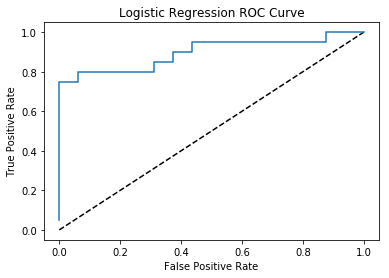

In [65]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show();

In [66]:
y_pred_prob = pipeline.predict_proba(x_val)[:,1]
roc_auc_score(y_val, y_pred_prob)

0.896875

In [67]:
cv_scores = cross_val_score(pipeline, x, y, cv=5, scoring='roc_auc')
cv_scores

array([0.828125, 0.903125, 0.99375 , 0.821875, 0.859375])

## K-Neighbors

In [68]:
steps = [('scaler', StandardScaler()), ('classifier', KNeighborsClassifier())]
pipeline = Pipeline(steps)
parameters = {'classifier__n_neighbors':np.arange(1, 50)}

In [69]:
cv = GridSearchCV(pipeline, param_grid=parameters)
cv.fit(x_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classifier', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'classifier__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [70]:
y_pred = cv.predict(x_val)

In [71]:
print(cv.best_params_)

{'classifier__n_neighbors': 7}


In [72]:
print(cv.score(x_val, y_val))

0.8611111111111112


In [73]:
print(classification_report(y_val, y_pred))

             precision    recall  f1-score   support

          0       0.76      1.00      0.86        16
          1       1.00      0.75      0.86        20

avg / total       0.89      0.86      0.86        36



## Deep Learning

In [74]:
def to_string(model):
    stringlist = []
    model.summary(print_fn=lambda x: stringlist.append(x))
    short_model_summary = "\n".join(stringlist)
    return short_model_summary

In [75]:
# n_cols = x.shape[1]
# # target = y
# target = to_categorical(y)
# early_stopping_monitor = EarlyStopping(patience=2)
# # n_nodes = range(n_cols)
# n_nodes = range(n_cols//2, n_cols*3//2, 2)
# model_lst = []

# max_acc = -1
# max_median_acc = -1
# max_max_acc = -1
# for i in n_nodes:
#     for j in n_nodes:
#         for k in n_nodes:
#             history_lst = []
#             for _ in range(10):
#                 model = Sequential()
#                 model.add(Dense(i, activation='relu', input_shape=(n_cols,), use_bias=True))
#                 model.add(Dense(j, activation='relu', use_bias=True))
#                 model.add(Dense(k, activation='relu', use_bias=True))
#                 model.add(Dense(2, activation='softmax', use_bias=True))
#                 optim = optimizers.SGD(lr=0.008)
#                 model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])
#                 history = model.fit(x, target, shuffle=False, validation_split=0.20, epochs=500, callbacks = [early_stopping_monitor], verbose=False)
#                 history_lst.append(history.history['val_accuracy'][-1])

#             accuracy = np.mean(history_lst)
#             std = np.std(history_lst)
#             maxx = np.max(history_lst)
#             median = np.median(history_lst)
            
#             if accuracy > max_acc:
#                 print(i,' ',j,' ',k, ' accuracy', accuracy, 'std', std, 'max', maxx, 'median', median,'-- MAX MEAN')
#                 model.save('model_file_mean.h5')
#                 max_acc = accuracy
#                 model_lst.append({'model': to_string(model), 'accuracy': accuracy, 'std': std, 'max': maxx, 'median': median})
            
#             if maxx > max_max_acc:
#                 print(i,' ',j,' ',k, ' accuracy', accuracy, 'std', std, 'max', maxx, 'median', median,'-- MAX MAX')
#                 model.save('model_file_max.h5')
#                 max_max_acc = maxx
#                 model_lst.append({'model': to_string(model), 'accuracy': accuracy, 'std': std, 'max': maxx, 'median': median})
                
#             if median > max_median_acc:
#                 print(i,' ',j,' ',k, ' accuracy', accuracy, 'std', std, 'max', maxx, 'median', median,'-- MAX MEDIAN')
#                 model.save('model_file_median.h5')
#                 max_median_acc = median
#                 model_lst.append({'model': to_string(model), 'accuracy': accuracy, 'std': std, 'max': maxx, 'median': median})

In [76]:
best_history_saved = best_history
best_model_saved = best_model
# best_model_saved.save('model_min_loss.h5')

In [77]:
max_acc = -1
min_loss = np.inf
best_history = None
best_model = None

In [78]:
n_cols = x.shape[1]
# target = y
target = to_categorical(y)
early_stopping_monitor = EarlyStopping(patience=2)


history_lst = []
for _ in range(50):
    model = Sequential()
    model.add(Dense(25, activation='relu', input_shape=(n_cols,), use_bias=True, kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(25, activation='relu', use_bias=True, kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(25, activation='relu', use_bias=True, kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(2, activation='softmax', use_bias=True, kernel_regularizer=regularizers.l2(0.0001)))
    optim = optimizers.SGD(lr=0.008)
    model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(x, target, shuffle=False, validation_split=0.20, epochs=500, callbacks = [early_stopping_monitor], verbose=False)
    history_lst.append(history.history['val_loss'][-1])
    if history.history['val_loss'][-1] < min_loss:
        min_loss = history.history['val_loss'][-1]
        best_history = history
        best_model = model
        print("better model found")

better model found
better model found
better model found
better model found
better model found
better model found


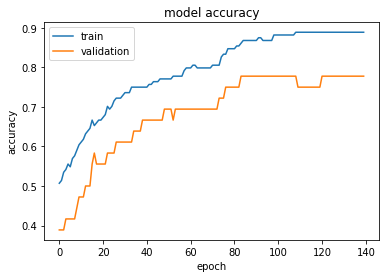

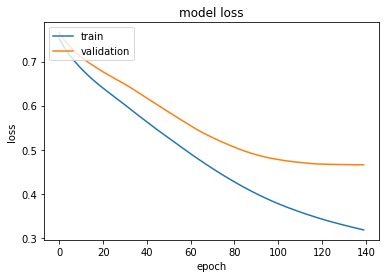

In [79]:
#  "Accuracy"
plt.plot(best_history.history['accuracy'])
plt.plot(best_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(best_history.history['loss'])
plt.plot(best_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [80]:
best_history.history['val_accuracy'][-1]

0.7777778

In [81]:
predictions = best_model.predict(x_test)
predictions = [i[1] for i in predictions]

In [82]:
def save_result(predictions, file_name='results.csv'):
    results = pd.DataFrame()
    results['patient_id'] = patient_id_test
    results['heart_disease_present'] = predictions
    results.to_csv('results.csv', index=False)
    return results

In [83]:
results = save_result(predictions)
results.head()

,patient_id,heart_disease_present
0,olalu7,0.633123
1,z9n6mx,0.084140
2,5k4413,0.891190
3,mrg7q5,0.153654
4,uki4do,0.921744


In [84]:
len(results)

90